In [1]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

import warnings
warnings.filterwarnings('ignore')

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":3.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.Spectral_r
savedir= '/private/home/sdascoli/recur/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Runs

In [65]:
runs = []
logs = []

paths = [
    #'/checkpoint/pakamienny/recur/paper/base',
    '/checkpoint/fcharton/recur/final/large',
    #'/checkpoint/sdascoli/recur/final/random',
    '/checkpoint/sdascoli/recur/paper/large'
       ]
#base = '/checkpoint/pakamienny/recur/final/base'
#base = '/checkpoint/fcharton/recur/final/large'
#base = '/checkpoint/sdascoli/recur/final/large'

NaN = np.nan
Infinity = np.nan

for path in paths:

    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        try : 
            run = {}
            args = pickle.load(open(dirname+'/params.pkl', 'rb'))
            run['args'] = args
            if 'use_sympy' not in args:
                setattr(args,'use_sympy',False)
            setattr(args, 'extra_constants', '')
            run['logs'] = []
            run['num_params'] = []
            #logfile = glob.glob(dirname+'/*.err')[-1]
            logfile = dirname+'/train.log'
            f = open(logfile, "r")
            for line in f.readlines():
                if '__log__' in line:
                    log = eval(line[line.find('{'):].rstrip('\n'))
                    if not run['logs']: run['logs'].append(log)
                    else: 
                        if log['valid1_recurrence_beam_acc'] != run['logs'][-1]['valid1_recurrence_beam_acc']: run['logs'].append(log)
    #                elif '(encoder)' in line:
    #                    run['num_params_enc'] = eval(line.split(' ')[-1].rstrip('\n'))
    #                elif '(decoder)' in line:
    #                    run['num_params_dec'] = eval(line.split(' ')[-1].rstrip('\n'))
    #            run['num_params'] = run['num_params_enc']+run['num_params_dec']
            f.close()
            args.output_dir = Path(dirname)
            runs.append(run)
        except Exception as e: 
            print(e)
            print('failed !'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
latest = min([len(run['logs']) for run in runs])-1
print('latest : ',latest)
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/checkpoint/fcharton/recur/final/large/
4 runs found
/checkpoint/fcharton/recur/final/large/float_sequences_True_output_numeric_True_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001
/checkpoint/fcharton/recur/final/large/float_sequences_True_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001
/checkpoint/fcharton/recur/final/large/float_sequences_False_output_numeric_True_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001
/checkpoint/fcharton/recur/final/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001
0 fails
/checkpoint/sdascoli/recur/paper/large/
2 runs found
/checkpoint/sdascoli/recur/paper/large/float_sequences_True_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001
/checkpoint/sdascoli/recur/paper/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001
0 fails
latest :  47


# Performance

float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001 [] 91 78.7
float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001 [] 48 77.0


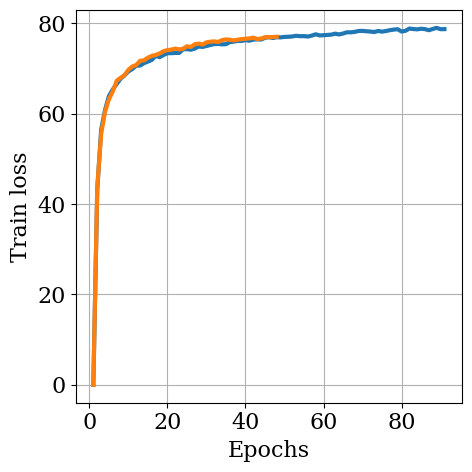

In [64]:
constraints = {
    'float_sequences':False,
    'output_numeric':False,
    #'real_series':True,
    #'dimension':[1,2],
    #'prob_rand':0.1,
    #'n_enc_layers':4,
    #'n_dec_layers':4,  
    #'prob_rand':0.0,
    #'curriculum_n_ops':False,
    #'optimizer':"adam_inverse_sqrt,lr=0.0006"
    'batch_size':32,
}
selected_runs, selected_params = select_runs(runs, params, constraints)
latest = min([len(run['logs'])-1 for run in selected_runs])
latest = -1

plt.figure(figsize=(5,5))

for run in selected_runs[:]:
    args = run['args']
    latest = len(run['logs'])
    loss       = [run['logs'][t]['valid1_recurrence_xe_loss'] for t in range(latest)][1:]
    correct    = [run['logs'][t]['valid1_recurrence_correct'] for t in range(latest)]
    perfect    = [run['logs'][t]['valid1_recurrence_perfect'] for t in range(latest)]
    valid      = [run['logs'][t]['valid1_recurrence_beam_acc'] for t in range(latest)]
    additional = [run['logs'][t]['valid1_recurrence_additional_1'] for t in range(latest)]
    if valid: print(Path(args.dump_path).name, run['num_params'], latest, valid[-1])
    label = 'With sympy' if args.use_sympy else 'Without sympy'
    #label = 'dim {}'.format(lab)
    y = valid
    plt.plot(range(1,len(y)+1), y, label=label)

#plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Train loss')
#plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'simplification_loss_{}.pdf'.format('float' if args.float_sequences else 'int'))
plt.show()

41.3 & 49.3 & 55.4
40.8 & 49.0 & 55.3
65.7 & 37.1
66.3 & 37.5


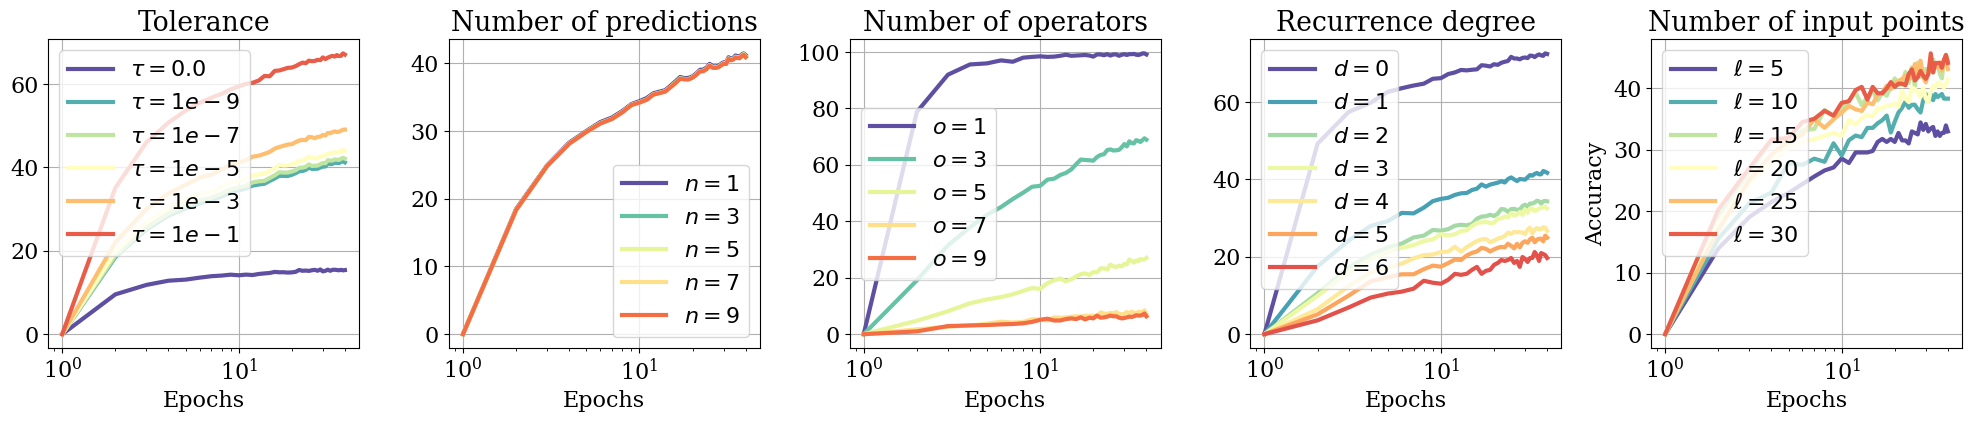

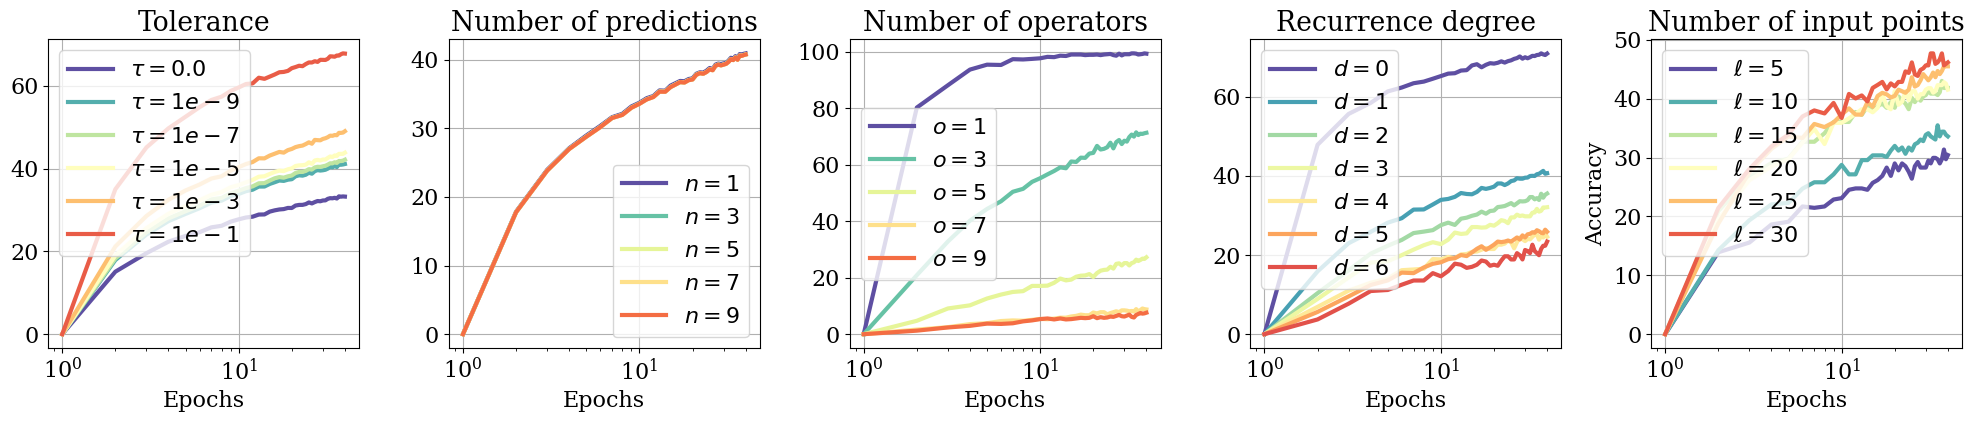

15.48
additional [41.33, 41.61, 41.89, 42.4, 43.19, 44.2, 46.21, 49.3, 55.37, 67.59]
n_predictions [41.59, 41.46, 41.44, 41.44, 41.41, 41.39, 41.36, 41.36, 41.33, 41.33]
ops [99.23444976076556, 91.67374681393373, 69.99182338511856, 39.767054908485854, 28.036529680365298, 15.720081135902637, 6.885593220338983, 6.829268292682927, 6.7164179104477615, 6.534090909090909]
deg [72.5780836421387, 42.20485396955985, 34.496919917864474, 33.063427800269906, 27.620783956244303, 24.671916010498688, 21.22762148337596]
points_averaged [34.87782451937363, 38.11708010849246, 41.61924722964699, 40.85246027726766, 45.07810368330908, 45.402345702731125, 48.214285714285715]
33.53
additional [40.8, 41.17, 41.5, 42.11, 42.77, 43.89, 45.92, 49.02, 55.29, 67.89]
n_predictions [41.05, 40.89, 40.84, 40.83, 40.81, 40.81, 40.8, 40.8, 40.8, 40.8]
ops [99.38461538461539, 91.76882661996497, 70.8, 43.08510638297872, 26.555246053853296, 15.779467680608365, 9.405405405405405, 5.373831775700935, 7.491486946651532, 5.7422

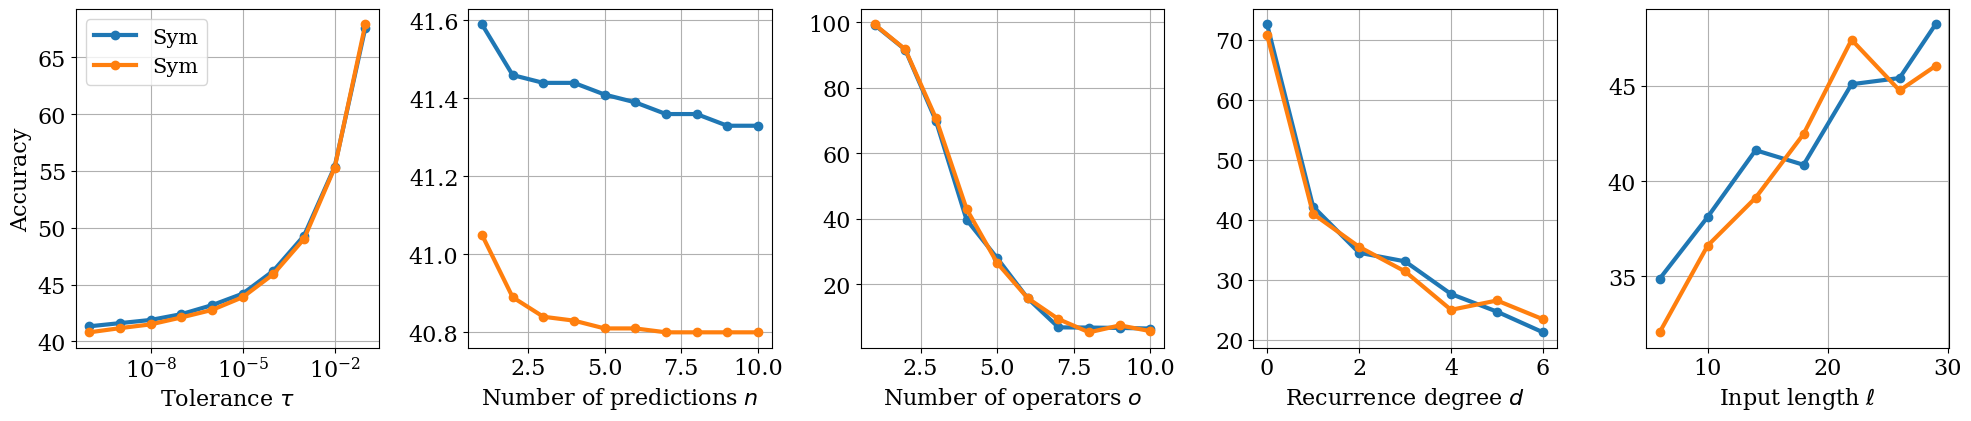

In [4]:
# chunk the inputs lens
chunk_size = 4
for run in selected_runs:
    keys = [k for k in run['logs'][0].keys() if 'points' in k]
    x = [int(k.split('_')[-1]) for k in keys]
    for length in x[::chunk_size]:
        lengths = range(length, min(max(x),length+chunk_size))
        if not lengths: continue
        keys_to_average = [f'valid1_recurrence_beam_acc_n_input_points_{l}' for l in lengths]
        average_acc =  np.mean([run['logs'][latest][k] for k in keys_to_average])
        run['logs'][latest][f'valid1_recurrence_beam_acc_n_input_points_averaged_{int(np.mean(lengths))}'] =  average_acc
        
keys = ['valid1_recurrence_additional_2', 'valid1_recurrence_additional_9', 'valid1_recurrence_additional_10']
for run in selected_runs:
    print(' & '.join(['{:.1f}'.format(run['logs'][latest][key]) for key in keys]))

key_list = [['valid1_recurrence_beam_acc_n_ops_{}'.format(i) for i in range(1,6)], ['valid1_recurrence_beam_acc_n_ops_{}'.format(i) for i in range(1,11)]]
for run in selected_runs:
    accs = []
    for keys in key_list:
        accs.append(np.mean([run['logs'][latest][key] for key in keys]))
    print(' & '.join(['{:.1f}'.format(x) for x in accs]))
        
#########
metrics = ['additional', 'n_predictions', 'ops', 'deg', 'points']
legends = ['\\tau','n','o', 'd', '\ell']
labels = ['Tolerance', 'Number of predictions', 'Number of operators', 'Recurrence degree', 'Number of input points']

for run in selected_runs:
    args = run['args']
    fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        keys = keys[::max(1,len(keys)//5)]
        for j, key in enumerate(keys):
            label = int(key.split('_')[-1])
            if metric == 'additional': label = args.more_tolerance.split(',')[int(label)-1]
            acc = [run['logs'][t][key] for t in range(len(run['logs'][:latest]))]
            axarr[i].plot(range(1, len(acc)+1), acc, label='${}={}$'.format(legends[i],label), color = cmap(j/len(keys)))
        axarr[i].set_title(labels[i])
        axarr[i].legend()
    for ax in axarr:
        ax.set_xscale('log')
        ax.set_xlabel('Epochs')
    #for n, ax in enumerate(axarr):
    #    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
    axarr[-1].set_ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig(savedir+'acc_vs_time_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
    plt.show()    

##########
metrics = ['additional', 'n_predictions', 'ops', 'deg', 'points_averaged']
labels = [ 'Tolerance $\\tau$', 'Number of predictions $n$','Number of operators $o$', 'Recurrence degree $d$', 'Input length $\ell$']
        
suffix = ''
fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
for run in selected_runs:
    args = run['args']
    run['logs'][-1]
    for i, metric in enumerate(metrics):
        if metric == 'ops':
            keys = [k for k in list(run['logs'][latest].keys())[::args.dimension] if metric in k]
        else:
            keys = [k for k in run['logs'][latest].keys() if metric in k]
        if metric == 'additional':
            keys = keys[1:]
            x = [eval(x) for x in args.more_tolerance.split(',')[1:]]
            print(run['logs'][latest]["valid1_recurrence_additional_1"])
            axarr[i].set_xscale('log')
        elif metric == 'ops':
            x = [int(k.split('_')[-1])//args.dimension for k in keys]
        #elif metric == 'points_averaged':
        #    x = [int(k.split('_')[-1])*args.dimension for k in keys]
        else:
            x = [int(k.split('_')[-1]) for k in keys]
        y = [run['logs'][latest][k] for k in keys]
        print(metric, y)
        label = 'Num' if run['args'].output_numeric else 'Sym'
        if args.prob_rand: 
            label += ' $p_{{rand}}={}$'.format(args.prob_rand)
            suffix = '_rand'
        elif args.dimension>1: 
            label += ' dim={}'.format(args.dimension)
            suffix = '_multidim'
        axarr[i].plot(x, y, label = label, marker='o')
        axarr[i].set_xlabel(r'{}'.format(labels[i]))
        #axarr[i].set_ylim(bottom=0, top=100)
        #axarr[i].set_yscale('symlog')
#for n, ax in enumerate(axarr):
#    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
axarr[0].set_ylabel('Accuracy')
axarr[0].legend(fontsize=15)
plt.tight_layout()
title = 'acc_vs_difficulty_{}'.format('float' if args.float_sequences else 'int') + suffix + '.pdf'
plt.savefig(savedir+title)
plt.show()    

# Evaluate run

In [ ]:
for run in selected_runs:
    
    res = {}
    
    for group, ops in od_groups.items():
        
        args = run['args']
        new_args = copy.deepcopy(args)
        new_args.eval_size = 128
        new_args.batch_size_eval = 1000
        new_args.more_tolerance = '1e-10,0.001,0.01'
        #new_args.max_ops = 5
        #new_args.float_constants = None
        #new_args.eval_noise = 0.0
        #new_args.eval_noise_type = 'additive'
        
        new_args.extra_unary_operators = 'id'
        new_args.operators_to_remove = ','.join(set(all_ops)-set(id_groups['base']+ops))
        
        new_args.operators_to_remove = ','.join(set(all_ops)-set(id_groups['base']))
        new_args.extra_unary_operators = ','.join(ops)
        
        
        scores = eval_run(run, new_args)
        print(new_args.operators_to_remove, ' & '.join(['{:.1f}'.format(scores['valid1_recurrence_additional_'+str(i)]) for i in range(1,4)]))
        res[group] = scores['valid1_recurrence_additional_1']

    print(res)

In [ ]:
perfs_num = {'base': 34.375, 'div': 26.5625, 'sqrt': 35.15625, 'exp': 39.0625, 'trig': 29.6875}
perfs_sym = {'base': 64.84375, 'div': 57.8125, 'sqrt': 61.71875, 'exp': 57.8125, 'trig': 50.0}


perfs_num = {'poly': 37.5, 'hyper': 32.03125, 'fresnel': 28.125, 'bessel': 23.4375}
perfs_sym = {'poly': 79.6875, 'hyper': 34.375, 'fresnel': 27.34375, 'bessel': 27.34375}


labels = perfs_num.keys()
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(4,5))
rects1 = ax.bar(x - width/2, [round(x) for x in perfs_num.values()], width, label='Numeric')
rects2 = ax.bar(x + width/2, [round(x) for x in perfs_sym.values()], width, label='Symbolic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, fontsize=15)
ax.bar_label(rects1, fontsize=12, rotation=0)
ax.bar_label(rects2, fontsize=12, rotation=0)
ax.set_ylim(top=max(list(rects1.datavalues)+list(rects2.datavalues))+20)
ax.legend()
ax.grid(False)
fig.tight_layout()
plt.savefig(savedir+'acc_vs_group_{}.pdf'.format('id' if 'base' in perfs_num else 'ood'))
plt.show()

In [ ]:
for idx in [1,3]:
    
    run = selected_runs[idx]
    args = run['args']
    new_args = copy.deepcopy(args)
    new_args.eval_size = 128
    new_args.batch_size_eval = 128
    new_args.more_tolerance = '1e-10,0.001,0.01'
    #new_args.prob_rand = 0.1
    new_args.eval_vebose = 2
    new_args.eval_vebose_print = True
    #new_args.eval_noise = 1

    scores = eval_run(run, new_args)
    print(' & '.join(['{:.1f}'.format(scores['valid1_recurrence_additional_'+str(i)]) for i in range(1,4)]))
    print(scores)

# In distribution

In [14]:
run = selected_runs[-1]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

Reloading checkpoint from /checkpoint/sdascoli/recur/paper/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 2 / iteration 18750 ...


0 0
0 0
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'' 0 0
0 1
0 1
0 1
0 1
0 2
0 2
0 2
1 0
1 0
1 0
1 0
1 1
1 1
1 1
1 1
1 2
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'' 1 2
2 0
2 0
2 0
2 0
2 1
2 1
division by zero 2 1
2 1
2 2
2 2
2 2


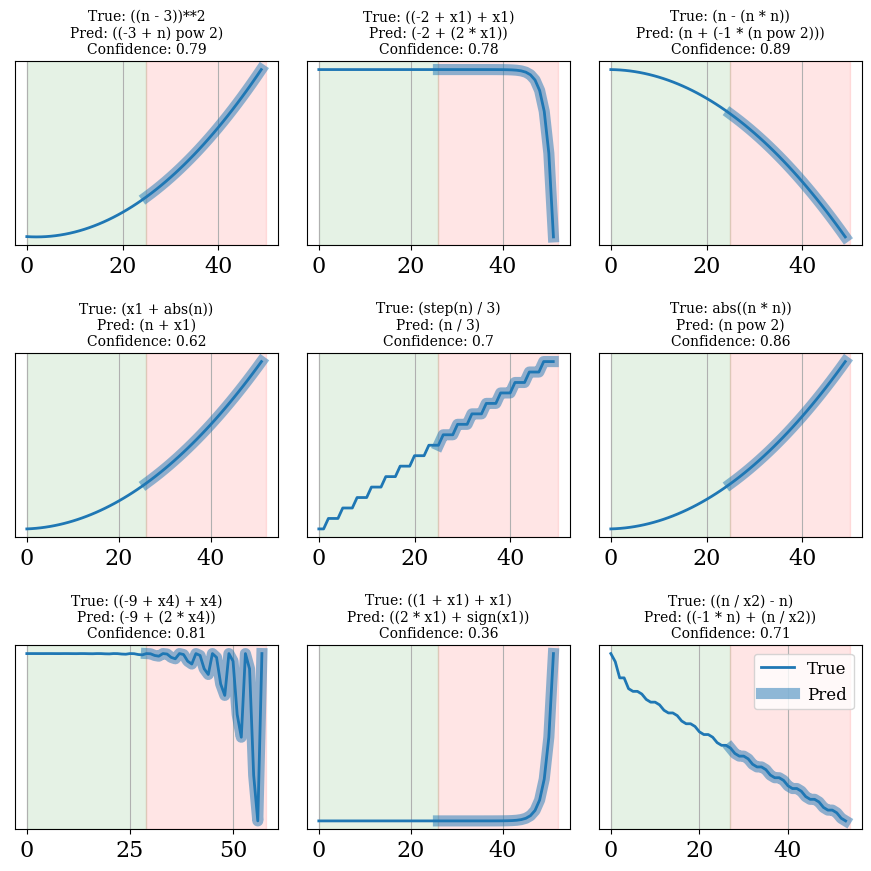

In [15]:
n = 3
failure_only = False
use_sympy = False

fig, axarr = plt.subplots(n,n,figsize=(n*3,n*3))
n_errors = 0
for i in range(n):
    for j in range(n):
        while True:
            try:
                tree, pred_tree, series, preds, score = predict(args, env, modules, gen_kwargs={'nb_ops':2, 'length':25})
                if args.prob_rand and "rand" not in tree.prefix(): continue
                print(i,j)
                if np.isnan(np.sum(series)) or np.isnan(np.sum(preds)): continue
                ending = np.array(series[-5:]); gaps = abs(ending[1:]-ending[:-1])
                if len(set(gaps))<2: continue # discard uninteresting series                            
                if failure_only is None: pass
                elif failure_only:
                    if abs((series[-1]-preds[-1])/series[-1])<0.1: continue
                else: 
                    if abs((series[-1]-preds[-1])/series[-1])>1e-2: continue

                confidence = 10**score
                if use_sympy: 
                    pred, true = sympy_infix(pred_tree), sympy_infix(tree)
                else:
                    pred, true = readable_infix(pred_tree), readable_infix(tree)
                #axarr[i,j].plot(series)
                #axarr[i,j].plot(preds, ls='--')
                length = len(series)//args.dimension
                axarr[i,j].axvspan(0, length//2, alpha=0.1, color='green')
                axarr[i,j].axvspan(length//2, len(series)//args.dimension, alpha=0.1, color='red')
                for dim in range(args.dimension):
                    axarr[i,j].plot(range(length), series[dim::args.dimension], color='C%d'%dim, lw=2, label='True' if dim==0 else '')
                    axarr[i,j].plot(range(length//2, length), preds[dim::args.dimension][length//2:], color='C%d'%dim, lw=8, alpha=.5, label='Pred' if dim==0 else '')
                break
            except Exception as e:
                print(e, end=' ')
                #if n_errors>1000: break
                n_errors += 1
        axarr[i,j].set_title(f'True: {true}\nPred: {pred}\nConfidence: {confidence:.2}', fontsize=10)
        #axarr[i,j].set_yscale('symlog')
        #axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])    
axarr[-1,-1].legend(fontsize=12)
        
plt.tight_layout()
title = 'failure' if failure_only else 'success'
title += '_{}'.format('float' if args.float_sequences else 'int', args.dimension)
if args.prob_rand: 
    title += '_rand'
elif args.dimension>1: 
    suffix += '_multidim'
title += '.pdf'
plt.savefig(savedir+title)
plt.show()

# Out of distribution

In [51]:
run = selected_runs[-1]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

src /checkpoint/sdascoli/recur/paper/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src hi
<module 'src' from '/checkpoint/sdascoli/recur/paper/large/float_sequences_True_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src/__init__.py'>


Reloading checkpoint from /checkpoint/sdascoli/recur/paper/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 41 / iteration 384375 ...


(x_0_1 add (n pow 2))
((n pow 2) add abs(x_0_1))
((n pow 2) add step(x_0_1))
abs((x_0_1 add (n pow 2)))
(x_0_1 add step((n pow 2)))
step((x_0_1 add (n pow 2)))
(x_0_1 add (step(n) pow 2))
((n pow 2) add abs(step(x_0_1)))
((n pow 2) add (x_0_1 mul sign(n)))
(x_0_1 add ((n pow 2) mul sign(n)))
(x1 + (n pow 2))
9455 9455
0.0


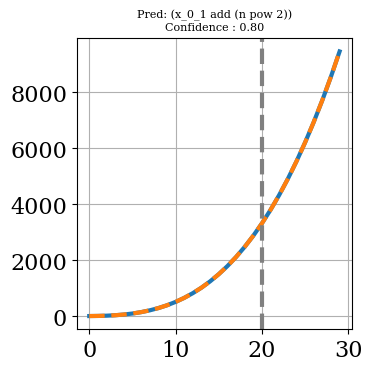

In [55]:
from scipy.special import erf, factorial, gamma
f = lambda n : scipy.special.dawsn(n)
#f = lambda n : np.arctanh(1/(n+1))
f = lambda n : np.log(factorial(n))
f = lambda n : int(n*(n+1)*(2*n+1)/6)
#f = lambda n : np.tan(n)*np.random.normal()
#f = lambda n : scipy.special.dawsn(n)
#f = lambda n : np.exp(np.pi*np.sqrt(2*n/3))/(4*n*np.sqrt(3))
#f = lambda n : np.cos(n)
# np.exp(np.pi*np.sqrt(2*n/3))/(4*n*np.sqrt(3))
length = 20
pred_len = 10

fig, ax = plt.subplots(1,1,figsize=(4,4))
series = [f(n) for n in range(1,length+pred_len+1)]
#series=[1,1,2,5,14,42,132,429,1430,4862,16796,58786, 208012,742900,2674440,9694845,35357670,129644790, 477638700,1767263190,6564120420,24466267020, 91482563640,343059613650,1289904147324, 4861946401452,18367353072152,69533550916004, 263747951750360,1002242216651368,3814986502092304]
#series = [logistic(n, 3, 0.5) for n in range(length)]

tree, pred, _, preds, score = predict(args, env, modules, series=series[:length], beam_length_penalty=None, beam_size=10, verbose=True, pred_len=pred_len, nonrec_only=False)#, rec_only=True)
print(readable_infix(pred))
print(series[-1],preds[-1])
print((series[-1] - preds[-1])/series[-1])
confidence = 10**score
#pred = readable_infix(pred)
ax.plot(series)
ax.plot(preds, ls='--')
#ax.plot([n * np.log(n) for n in range(1,length+1)], ls='--')
ax.axvline(x=length, ls='--', color='grey')
plt.title(f'Pred: {pred}\nConfidence : {confidence:.2f}', fontsize=8)
#plt.yscale('symlog')
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show()

In [ ]:
x = np.linspace(0,30, 100)
#plt.plot(x, np.arccosh(x))
#plt.plot(x, np.log(2*x-1/(x**1.5)))
#plt.semilogy(x, np.cosh(x))
#plt.semilogy(x, 1/np.sin(2/np.exp(x)))
plt.semilogy(x, scipy.special.dawsn(x))
plt.semilogy(x, 1/((x + abs((x - ((np.pi - 1) / (np.sqrt(n) * n)))))))
#for op in od_groups['fresnel']:
#    if op=='fresnel': continue
#    plt.plot(x, getattr(scipy.special, op)(x), label=op)
plt.legend()
plt.show()

# Embeddings

In [ ]:
run = selected_runs[1]
env, modules, trainer, evaluator = load_run(run)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

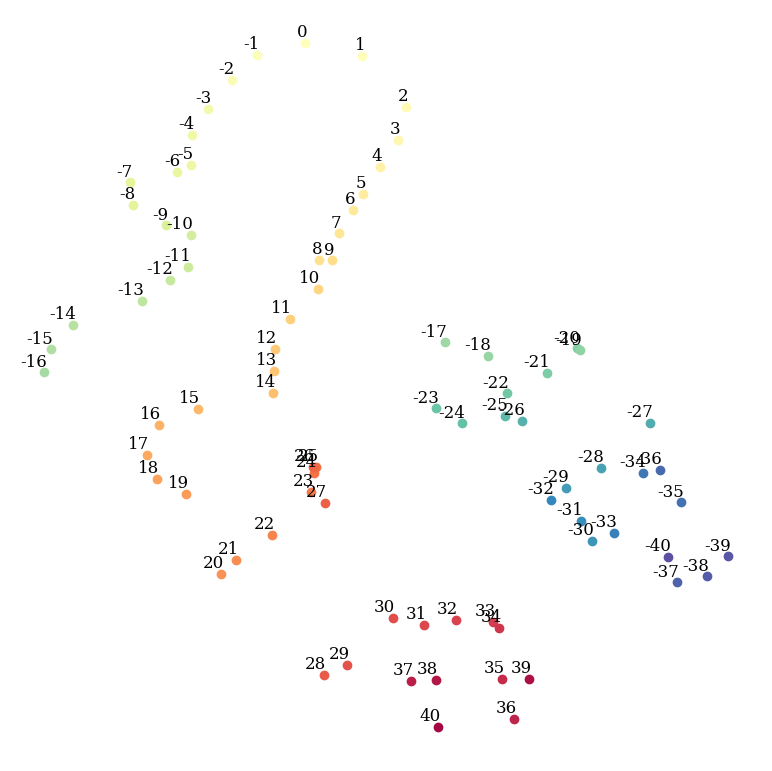

In [91]:
def get_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    if args.float_sequences: smallest, largest = -40,40
    else: smallest, largest = 0, 80
    for number in range(smallest, largest+1):
        if args.float_sequences: word = 'E'+str(number-args.float_precision-1)
        else: word = str(number)
        idx = env.input_word2id[word]
        tokens.append(embeddings[idx])
        labels.append(str(number))
    return labels, tokens

def get_output_labels_tokens(embeddings, env):
    "Creates and TSNE model and plots it"
    labels = []; tokens = []
    for word, idx in env.output_word2id.items():
        tokens.append(embeddings[idx])
        labels.append(word)
    return labels, tokens
            
def tsne_plot_2d(embeddings, env, n_words=500):
    
    labels, tokens = get_labels_tokens(embeddings, env) 
    tsne_model = TSNE( n_components=2, perplexity=40, init='pca', n_iter=1000, random_state=0)
    new_values = tsne_model.fit_transform(tokens)

    x = []; y = []
    for value in new_values:
        x.append(value[0]); y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x))[:n_words]:
        plt.scatter(x[i],y[i], color=cmap(i/min(n_words, len(x))))
        plt.annotate(labels[i], xy=(x[i], y[i]), fontsize=12, xytext=(2, 2), textcoords='offset points', ha='right', va='bottom')
    plt.axis(False)
    plt.tight_layout()
    plt.savefig(savedir+'embeddings_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
    plt.show()
       
tsne_plot_2d(encoder.embeddings.weight.cpu().detach().numpy(), env)

In [ ]:
plt.figure(figsize=(15,15))
embeddings = encoder.embeddings.weight.cpu().detach()
if args.float_sequences: smallest, largest = -80, 80
else: smallest, largest = 0, 80
similarity = torch.zeros(largest-smallest, largest-smallest)

for i1, w1 in enumerate(range(smallest, largest)):
    if args.float_sequences: w1 = 'E'+str(w1-args.float_precision)
    for i2, w2 in enumerate(range(smallest, largest)):
        if i1==i2: continue
        if args.float_sequences: w2 = 'E'+str(w2-args.float_precision)
        j1 = env.input_word2id[str(w1)]
        j2 = env.input_word2id[str(w2)]
        similarity[i1,i2] = torch.dot(embeddings[j1], embeddings[j2])/embeddings[j1].norm()/embeddings[j2].norm()

plt.matshow(similarity)
plt.grid(False)

nticks = 5
ticks = np.linspace(0,len(similarity), nticks)
labels = np.linspace(smallest, largest, nticks).astype(int)
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.tight_layout()
plt.savefig(savedir+'embedding_similarities_{}_{}.pdf'.format('float' if args.float_sequences else 'int', 'num' if args.output_numeric else 'sym'))
plt.show()

# OEIS

In [4]:
from oeis import load_oeis
lines, ids = load_oeis(length=30, path="/private/home/sdascoli/recur/OEIS_easy.txt")

run = selected_runs[-1]
args = run['args']
new_args = copy.deepcopy(args)
new_args.beam_size = 10
new_args.beam_length_penalty = 0
env, modules, trainer, evaluator = load_run(run, new_args)
encoder, decoder = modules["encoder"], modules["decoder"]
args = run['args']

10000 30.0
src /checkpoint/sdascoli/recur/paper/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src hi
<module 'src' from '/checkpoint/sdascoli/recur/paper/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/src/__init__.py'>


Reloading checkpoint from /checkpoint/sdascoli/recur/paper/large/float_sequences_False_output_numeric_False_batch_size_32_optimizer_adam_inverse_sqrt,lr=0.0001/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 39 / iteration 365625 ...


In [5]:
batch_size = 8
max_preds = 15

print('{:.0f} batches'.format(len(lines)/batch_size))
corrects = {k:0 for k in [1,max_preds]}
tol1     = {k:0 for k in [1,max_preds]}
tol2     = {k:0 for k in [1,max_preds]}
for ibatch, batch in enumerate(chunks(lines, batch_size)):
    inputs = [seq[:-max_preds] for seq in batch]
    try: preds, pred_series = predict_batch(new_args, env, modules, inputs, pred_len=max_preds,)
    except: continue
    for i in range(len(pred_series)): 
        pred = pred_series[i]
        seq_len = len(batch[i])
        if pred is None: continue
        true = batch[i][-max_preds:]
        #print(true, pred)
        for key in corrects:
            try: 
                max_error = max([abs(float(x-y)/float(y+1e-10)) for x,y in zip(true[:key], pred[:key])])
            except Exception as e: print(e); continue
            corrects[key] += int(max_error<1e-10)
            tol1[key] += int(max_error<0.001)
            tol2[key] += int(max_error<0.01)
        
    if ibatch%10==0: 
        total = (ibatch+1)*batch_size
        print('batch {}: '.format(ibatch),
              ' '.join(['{}: {:.1f}'.format(k, 100*corrects[k]/total) for k in corrects]),
              #' '.join(['{}: {:.1f}'.format(k, 100*tol1[k]/total) for k in tol1]),
              ' '.join(['{}: {:.1f}'.format(k, 100*tol2[k]/total) for k in tol2]))

1250 batches
batch 0:  1: 50.0 15: 25.0 1: 50.0 15: 25.0
batch 10:  1: 50.0 15: 26.1 1: 53.4 15: 26.1
batch 20:  1: 40.5 15: 22.0 1: 42.9 15: 22.0
batch 30:  1: 36.7 15: 20.6 1: 38.7 15: 21.0
batch 40:  1: 38.1 15: 22.6 1: 40.5 15: 22.9
batch 50:  1: 35.0 15: 20.6 1: 37.7 15: 20.8
batch 60:  1: 33.0 15: 19.1 1: 35.2 15: 19.5
batch 70:  1: 31.7 15: 17.4 1: 34.2 15: 18.1
batch 80:  1: 29.2 15: 15.9 1: 31.6 15: 16.5
batch 90:  1: 29.1 15: 15.1 1: 31.3 15: 15.7
batch 100:  1: 31.2 15: 15.6 1: 33.4 15: 16.1
batch 110:  1: 30.9 15: 15.2 1: 32.9 15: 15.7
batch 120:  1: 31.4 15: 15.4 1: 33.5 15: 15.9
batch 130:  1: 31.5 15: 15.2 1: 33.6 15: 15.6
batch 140:  1: 31.8 15: 15.2 1: 34.0 15: 15.9
batch 150:  1: 31.0 15: 14.8 1: 33.1 15: 15.4
batch 160:  1: 30.8 15: 14.4 1: 33.0 15: 15.0
batch 170:  1: 31.1 15: 14.4 1: 33.2 15: 15.0
batch 180:  1: 30.6 15: 13.7 1: 32.6 15: 14.3
batch 190:  1: 30.1 15: 13.4 1: 32.1 15: 14.1
batch 200:  1: 31.3 15: 15.0 1: 33.4 15: 15.7
batch 210:  1: 31.8 15: 15.2 1: 

In [ ]:
batch 0:  1: 37.5 15: 12.5 1: 37.5 15: 12.5
batch 10:  1: 40.9 15: 26.1 1: 43.2 15: 26.1
batch 20:  1: 35.7 15: 22.0 1: 36.9 15: 22.0
batch 30:  1: 34.3 15: 21.0 1: 35.5 15: 21.0
batch 40:  1: 34.8 15: 22.6 1: 36.3 15: 22.9
batch 50:  1: 32.1 15: 20.3 1: 33.8 15: 20.6
batch 60:  1: 30.3 15: 19.1 1: 32.2 15: 19.3
batch 70:  1: 29.6 15: 17.4 1: 32.0 15: 18.0
batch 80:  1: 27.9 15: 15.7 1: 30.2 15: 16.2
batch 90:  1: 27.2 15: 14.7 1: 29.5 15: 15.1

In [ ]:
def is_monotonic(seq):
    seq = np.array(seq)
    diff = seq[1:]-seq[:-1]
    if all(diff>=0) or all(diff<=0): return True
    else: return False

max_preds = 10
n_correct = 0
plot = True

for i, seq in enumerate(lines):
    #if i==100: break
    if is_monotonic(seq): continue
    input_seq = seq[:-max_preds]
    _, pred, _, pred_seq, score = predict(args, env, modules, series=input_seq, pred_len=max_preds)
    if seq[-max_preds:] != pred_seq[-max_preds:]: continue
    n_correct += 1
    print(i, ids[i], ', '.join(str(x) for x in input_seq[:10]), pred)
    #print(seq[-max_preds:], pred_seq[-max_preds:])
    pred = readable_infix(pred)
    
    if plot:
        plt.figure(figsize=(2,2))
        plt.plot(seq)
        plt.plot(pred_seq, ls='--')
        plt.axvline(x=len(input_seq), ls='--', color='grey')
        plt.title(f'Pred: {pred}', fontsize=8)
        plt.xticks([])
        plt.yticks([])
        plt.show()

# Attention maps

In [ ]:
run = selected_runs[1]
env, modules, trainer, evaluator = load_run(run)
args = run['args']
    
tree, pred_tree, series, preds, score = plot_attention(args, env, modules)

In [ ]:
def num_trees(L, p1, p2, n):
    if n==0: return L
    elif n==1: return p2*(L*L+1)/2 + p1*L
    else: return (1/(n+1)) * ((p1+2*L*p2)*(2*n-1)*num_trees(L, p1, p2, n-1) - p1*(n-2)*num_trees(L, p1, p2, n-2))
    #else: return ((p1 + 2*L*p2)*(2*n-1)*num_trees(p1, p2, L, n-1) − p1*(n−2)*num_trees(p1, p2, L, n-2)) / (n+1)
num_trees(1, 0, 1, 5)

num_int = []
num_float = []
num_int_skeleton = []
num_float_skeleton = []
nops = range(1,11)
for nop in nops:
    num_int_skeleton.append(num_trees(6, 4, 5, nop))
    num_float_skeleton.append(num_trees(6, 12, 4, nop))
    num_int.append(num_trees(27, 4, 5, nop))
    num_float.append(num_trees(31, 12, 4, nop))
    
plt.figure(figsize=(5,4))
plt.semilogy(nops, num_int, label='Full expressions')
#plt.semilogy(nops, num_float)
plt.semilogy(nops, num_int_skeleton, label='Skeletons')
#plt.semilogy(nops, num_float_skeleton)
plt.axhline(y=3e5*1/10, color='grey',ls='--', label='One epoch')
plt.xlabel('Number of operators')
plt.ylabel('Number of expressions')
plt.legend()
plt.tight_layout()
plt.savefig(savedir+'num_expressions.pdf')
plt.show()
print(' & '.join(['{:e}'.format(_).split('e')[-1] for _ in num_int]))
print(' & '.join(['{:e}'.format(_).split('e')[-1] for _ in num_float]))